In [1]:

%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import os
import pickle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import random
from mpl_toolkits.mplot3d import Axes3D
from skimage.feature import hog
from sklearn.svm import LinearSVC, SVC
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label
import time



%matplotlib inline

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Step 0: Load The Data

In [3]:
cars_dir =     './vehicles/*/*.png'
notcars_dir = './non-vehicles/*/*.png'
testimages_dir = './test_images/*.jpg'

cars_fnames = []
notcars_fnames = []
testimages_fnames = []
cars = []
notcars = []
testimages = []

i = 0
images = glob.glob(cars_dir)
for img_path in images:
    cars_fnames.append(img_path)
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    cars.append(img)
        
images = glob.glob(notcars_dir)
for img_path in images:
    notcars_fnames.append(img_path)
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    notcars.append(img)
    
images = glob.glob(testimages_dir)
for img_path in images:
    testimages_fnames.append(img_path)
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    testimages.append(img)

## Step 1: Dataset Summary & Visualization

In [4]:
n_cars = len(cars)
n_notcars = len(notcars)
image_shape = cars[0].shape

print('Number of car examples =', n_cars)
print('Number of not car examples =', n_notcars)
print('Image data shape =', image_shape)


Number of car examples = 8792
Number of not car examples = 8968
Image data shape = (64, 64, 3)


In [5]:
def plot_images_in_column(input_images, num_cols, figure_name, cmap = None):
    fig, axes = plt.subplots((int)((len(input_images) + 1) /num_cols), num_cols, figsize=(24, 20))
    fig = plt.gcf()
    fig.canvas.set_window_title(figure_name)
    
    print(figure_name)
    
    for ax, image in zip(axes.flat, input_images):
        if(cmap == "gray" or cmap == 'hot'):
            ax.imshow(image, cmap=cmap)
        elif(image.shape[2]==1):
            ax.imshow(image[:,:,0], cmap = cmap)
        else:
            ax.imshow(image, cmap=cmap)

    plt.show()

Cars


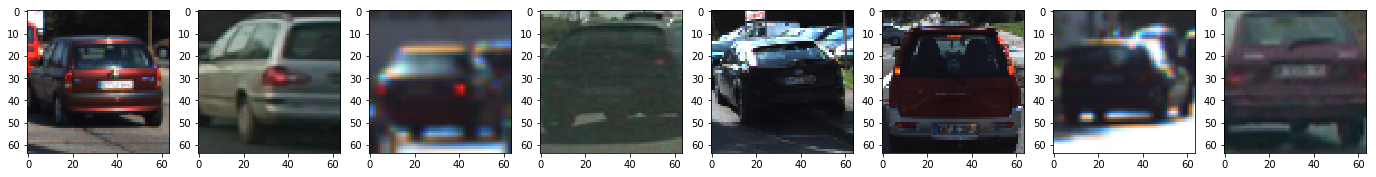

Not cars


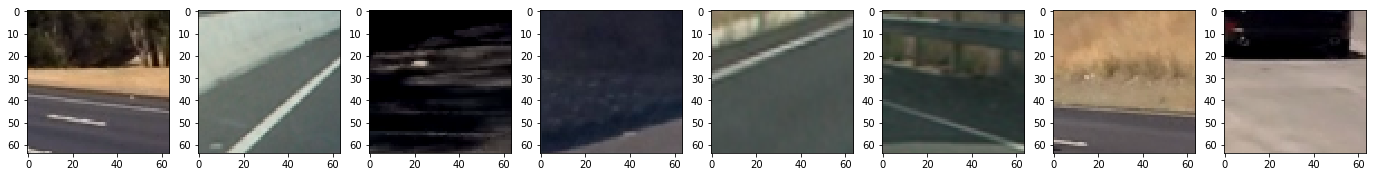

In [6]:
num_images = 8
car_samples = random.sample(list(cars), num_images)
notcar_samples = random.sample(list(notcars), num_images)

car_images = []
notcar_images = []
for sample in car_samples:
    car_images.append(sample)
for sample in notcar_samples:
    notcar_images.append(sample)

plot_images_in_column(car_images, num_images, 'Cars')
plot_images_in_column(notcar_images, num_images, 'Not cars')

From the sample images, car images have picture of cars from the back or the side from various angles.  The lighting seems to be differ a lot, with some images look to be with a lot of sun lights while others are images from the darkness.

# Step 2: Visualize color spaces

In [7]:
def plot3d_colorspaces(img, ptitle):
    
    print('------- ', ptitle)
    fig_img = plt.figure(figsize=(3,3))
    ax0 = fig_img.add_subplot(1,1,1)
    ax0.imshow(img, cmap=None)
    
    # Select a small fraction of pixels to plot by subsampling it
    scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
    img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

    # Convert subsampled image to desired color space(s)
#    img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_RGB2RGB) 
    img_small_HLS = cv2.cvtColor(img_small, cv2.COLOR_RGB2HLS)
    img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_RGB2HSV)
    img_small_YCrCb = cv2.cvtColor(img_small, cv2.COLOR_RGB2YCrCb)
    img_small_YUV = cv2.cvtColor(img_small, cv2.COLOR_RGB2YUV)
    img_small_LUB = cv2.cvtColor(img_small, cv2.COLOR_RGB2LUV)
    img_small_GRAY = cv2.cvtColor(img_small, cv2.COLOR_RGB2GRAY)

    img_small_rgb = img_small / 255.  # scaled to [0, 1], only for plotting

    # Create figure and 3D axes
    
    # figure parameters
    fig = plt.figure(figsize=(15, 8))
    fontsize = 12
    labelsize = 10
    pad = 6
    labelpad = 8

    def set_ax1(ax_lim):
        # Set axis limits
        ax1.set_xlim(*ax_lim[0])
        ax1.set_ylim(*ax_lim[1])
        ax1.set_zlim(*ax_lim[2])
        # Set axis labels and sizes
        ax1.tick_params(axis='both', which='major', labelsize=labelsize, pad=pad)
        ax1.set_xlabel(axis_labels[0], fontsize=fontsize, labelpad=labelpad)
        ax1.set_ylabel(axis_labels[1], fontsize=fontsize, labelpad=labelpad)
        ax1.set_zlabel(axis_labels[2], fontsize=fontsize, labelpad=labelpad)
        # Plot pixel values with colors given in colors_rgb
        ax1.scatter(
            pixels[:, :, 0].ravel(),
            pixels[:, :, 1].ravel(),
            pixels[:, :, 2].ravel(),
            c=img_small_rgb.reshape((-1, 3)), edgecolors='none')
        
    
    # RGB
    ax1 = fig.add_subplot(2,3,1,projection='3d')
    axis_limits=((0, 255), (0, 255), (0, 255))
    axis_labels=list('RGB')
    ax1.set_title('RGB')
    pixels=img_small
    set_ax1(ax_lim=axis_limits)
    
    # HLS
    ax1 = fig.add_subplot(2,3,2,projection='3d')
    axis_limits=((0, 255), (0, 255), (0, 255))
    axis_labels=list('HLS')
    pixels=img_small_HLS
    set_ax1(ax_lim=axis_limits)

    # HSV
    ax1 = fig.add_subplot(2,3,3,projection='3d')
    axis_limits=((0, 255), (0, 255), (0, 255))
    axis_labels=list('HSV')
    ax1.set_title('HSV')
    pixels=img_small_HSV
    set_ax1(ax_lim=axis_limits)

    # YCrCb
    ax1 = fig.add_subplot(2,3,4,projection='3d')
    axis_limits=((0, 255), (0, 255), (0, 255))
    axis_labels=list('Yrb')
    ax1.set_title('YCrCb')
    pixels=img_small_YCrCb
    set_ax1(ax_lim=axis_limits)

    # YUV
    ax1 = fig.add_subplot(2,3,5,projection='3d')
    axis_limits=((0, 255), (0, 255), (0, 255))
    axis_labels=list('YUV')
    ax1.set_title('YUV')
    pixels=img_small_YUV
    set_ax1(ax_lim=axis_limits)

    # LUB
    ax1 = fig.add_subplot(2,3,6,projection='3d')
    axis_limits=((0, 255), (0, 255), (0, 255))
    axis_labels=list('LUB')
    ax1.set_title('LUB')
    pixels=img_small_LUB
    set_ax1(ax_lim=axis_limits)
    
    
    plt.show()

    return None  

-------  Car Image 7529


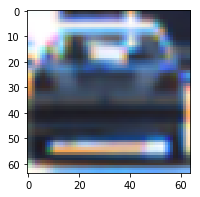

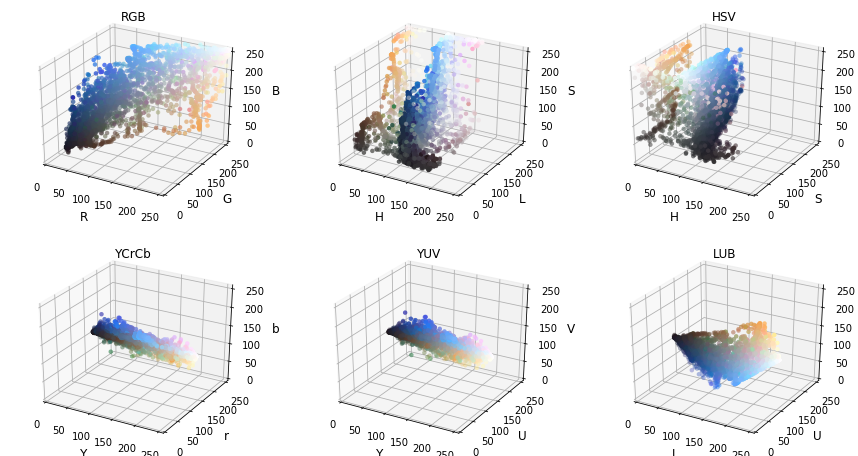

-------  Notcar Image 1254


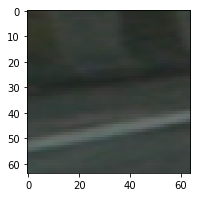

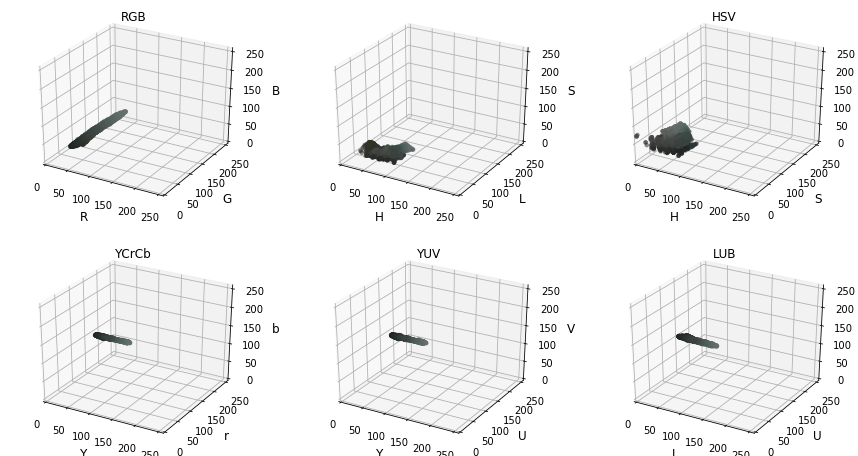

-------  Car Image 7291


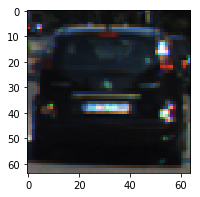

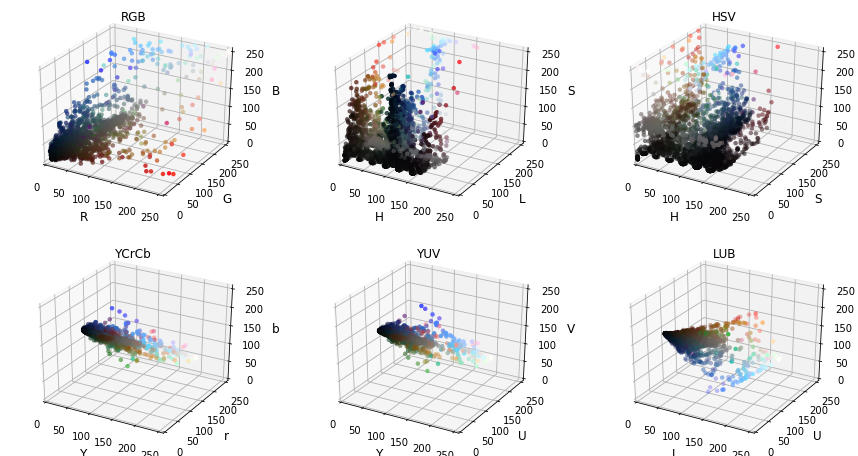

-------  Notcar Image 5454


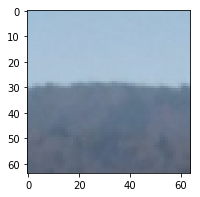

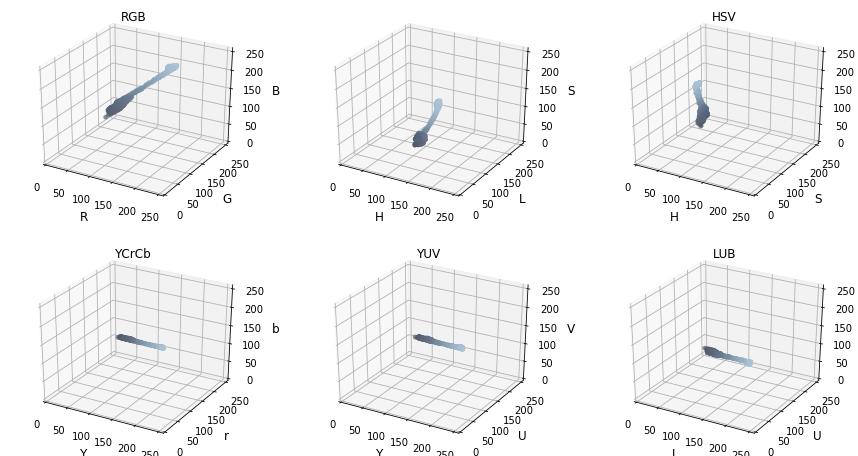

-------  Car Image 2448


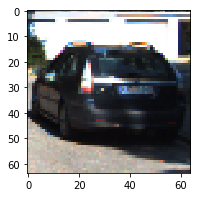

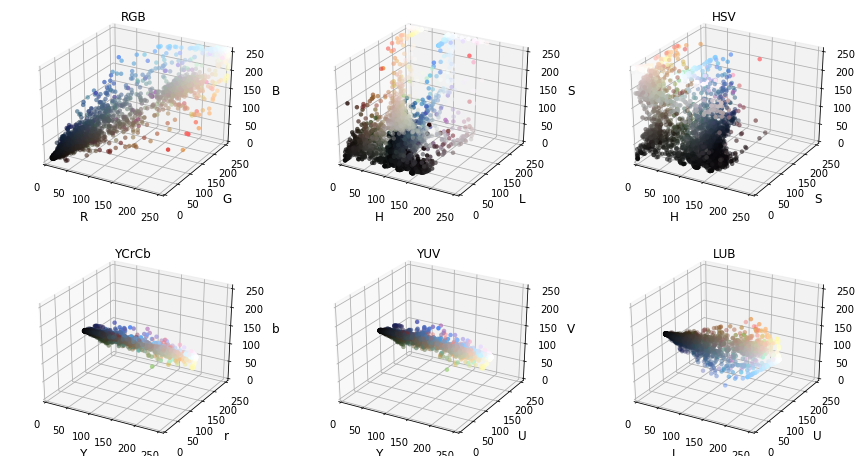

-------  Notcar Image 284


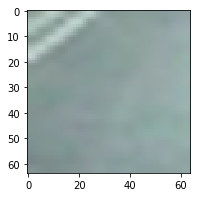

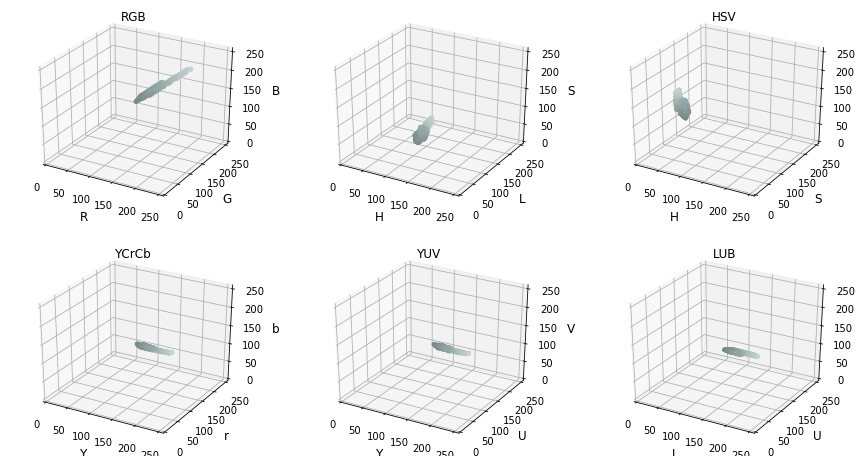

In [8]:
for i in range(3):
    num = random.randint(0,len(cars)-1)
    plot3d_colorspaces(cars[num], 'Car Image ' + str(num))
    
    num = random.randint(0,len(notcars)-1)
    plot3d_colorspaces(notcars[num], 'Notcar Image ' + str(num))

One thing I noticed was that YCrCb and YUV were nearly identical in most images.  Through iterations, they seem to produce most distinguishiable features.  At the end, YCrCb was used to separate car images from non-car images.

In [9]:
def plot_YCrCb(img, img_name):
    
    print(img_name)
    img_YCrCb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    fig = plt.figure(figsize=(15,10))
    plt.subplot(151)
    plt.imshow(img)
    plt.title('Orig Image')
    plt.subplot(152)
    plt.imshow(img_YCrCb[:,:,0], cmap='gray')
    plt.title('Y channel')
    plt.subplot(153)
    plt.imshow(img_YCrCb[:,:,1], cmap='gray')
    plt.title('Cr channel')
    plt.subplot(154)
    plt.imshow(img_YCrCb[:,:,2], cmap='gray')
    plt.title('Cb channel')
    plt.subplot(155)
    plt.imshow(img_YCrCb)
    plt.title('YCrCb Image')
    plt.show()

Car Image 1259


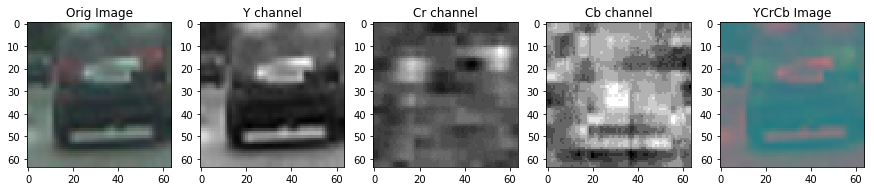

Car Image 3539


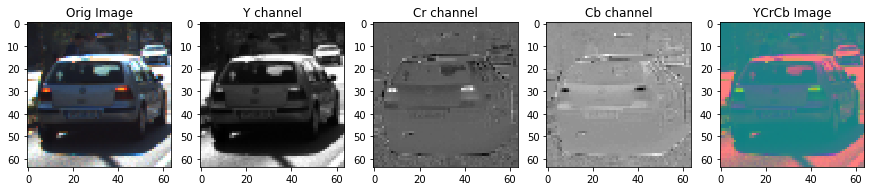

Car Image 2009


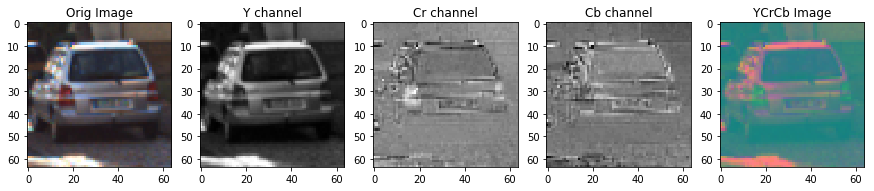

In [10]:
for i in range(3):
    num = random.randint(0,len(cars)-1)
    plot_YCrCb(cars[num], 'Car Image ' + str(num))

## Step 3: visualize HOG features

In [11]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [12]:
def plot_hog_features(img, img_name):
    pix_per_cell = 8
    cell_per_block = 2
    orient = 9

    img_ycrcb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    features_h, img_hog = get_hog_features(img_ycrcb[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    
    print(img_name)
    fig = plt.figure(figsize=(8,3))
    plt.subplot(131)
    plt.imshow(img)
    plt.title('Orig Image')
    plt.subplot(132)
    plt.imshow(img_ycrcb)
    plt.title('YCrCb image')
    plt.subplot(133)
    plt.imshow(img_hog, cmap='gray')
    plt.title('hog image')
    plt.show()    

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Car Image 6546


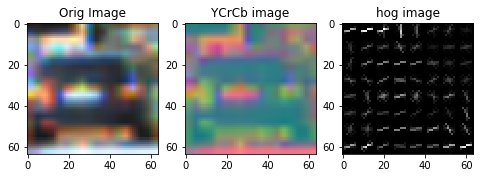

Not car Image 2403


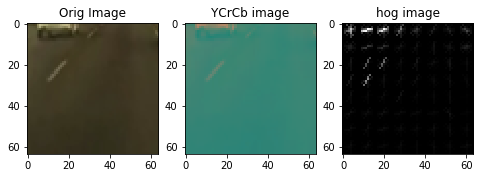

Car Image 4119


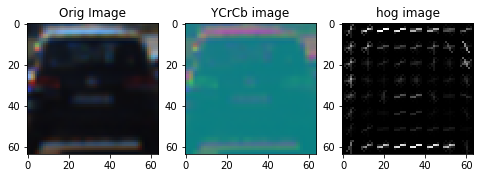

Not car Image 6355


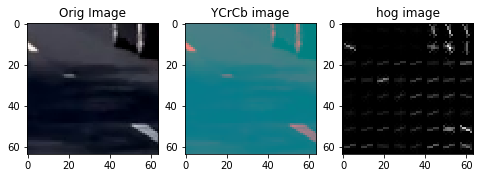

In [13]:
for i in range(2):
    num = random.randint(0,len(cars)-1)
    plot_hog_features(cars[num], 'Car Image ' + str(num))
    num = random.randint(0,len(notcars)-1)
    plot_hog_features(notcars[num], 'Not car Image ' + str(num))

## Step 4: Train SVM after combining and normalizing features

In [14]:
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [15]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [16]:
def single_img_features_old(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    """Extract spatial, color and hog features from single image
    Args:
        img (numpy.array): image in RGB format
        color_space: GRAY, RGB, HSV, LUV, HLS, YUV, YCrCb
        spatial_size (tuple): resize img before calculating spatial features
            default value is (32, 32)
        hist_bins (int): number of histogram bins, 32 by default
        orient (int): number of HOG orientations
        pix_per_cell (int): number of pixels in HOG cell
        cell_per_block (int): number of HOG cells in block
        hog_channel (int): channel to use for HOG features calculating, default 0
        spatial_feat (boolean): calculate spatial featues, default True
        hist_feat (boolean): calculate histogram featues, default True
        hog_feat (boolean): calculate HOG featues, default True
    Returns:
        features_vector (list(numpy.array)): list of feature vectors
    """
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        feature_image = cv2.cvtColor (img, getattr(cv2, 'COLOR_BGR2' + color_space))
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if color_space == 'GRAY':
            hog_features = get_hog_features(feature_image, orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        elif hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [17]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [18]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features_OLD(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    """Extract spatial, color and hog features from specified list of images
    Args:
        imgs (list): list of images in RGB format
        color_space: GRAY, RGB, HSV, LUV, HLS, YUV, YCrCb
        spatial_size (tuple): resize img before calculating spatial features
            default value is (32, 32)
        hist_bins (int): number of histogram bins, 32 by default
        orient (int): number of HOG orientations
        pix_per_cell (int): number of pixels in HOG cell
        cell_per_block (int): number of HOG cells in block
        hog_channel (int): channel to use for HOG features calculating, default 0
        spatial_feat (boolean): calculate spatial featues, default True
        hist_feat (boolean): calculate histogram featues, default True
        hog_feat (boolean): calculate HOG featues, default True
    Returns:
        features_vector (numpy.array)
    """
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        file_features = []
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            feature_image = cv2.cvtColor (image, getattr(cv2, 'COLOR_BGR2' + color_space))
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if color_space == 'GRAY':
                hog_features = get_hog_features(feature_image, orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            elif hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


In [19]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(image, params ):
    # Parameters extraction
    # HOG parameters
    cspace = params.cspace
    orient = params.orient
    pix_per_cell = params.pix_per_cell
    cell_per_block = params.cell_per_block
    hog_channel = params.hog_channel
    # Spatial parameters
    size = params.size
    # Histogram parameters
    hist_bins = params.hist_bins
    hist_range = params.hist_range
    
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      

    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)

    # Apply bin_spatial() to get spatial color features
    spatial_features = bin_spatial(feature_image, size)

    # Apply color_hist() 
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
    
    return np.concatenate((spatial_features, hist_features, hog_features))

In [20]:
# declare parameters
class FeaturesParameters():
    def __init__(self):
        # HOG parameters
        self.cspace = 'YCrCb'
        self.orient = 8
        self.pix_per_cell = 8
        self.cell_per_block = 2
        self.hog_channel = 'ALL'
        # Bin spatial parameters
        self.size = (16, 16)
        # Histogram parameters
        self.hist_bins = 32
        self.hist_range = (0, 256)

params = FeaturesParameters()


In [21]:
t=time.time()

car_features = list(map(lambda img: extract_features(img, params), cars))
notcar_features = list(map(lambda img: extract_features(img, params), notcars))

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


148.2 Seconds to extract HOG features...


In [22]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64) 
print(X.shape)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

print(len(y))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

(17760, 5568)
17760


In [23]:
# SVC
svc = LinearSVC()
#svc = SVC()
#svc = LinearSVC(C=1e-4, dual=False, max_iter=5)
#svc = SVC(C=0.5)

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

13.73 Seconds to train SVC...


In [24]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 15
print('My SVC predicts:     ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Test Accuracy of SVC =  0.9932
My SVC predicts:      [ 0.  0.  1.  0.  0.  1.  0.  1.  1.  0.  1.  1.  0.  1.  1.]
For these 15 labels:  [ 0.  0.  1.  0.  0.  1.  0.  1.  1.  0.  1.  1.  0.  1.  1.]
0.0042 Seconds to predict 15 labels with SVC


## step 5: sliding window

In [25]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [26]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [27]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'BGR2YUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

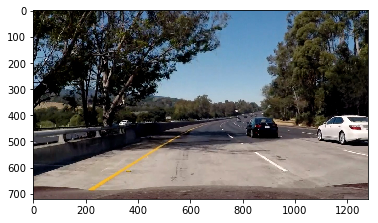

In [28]:
image = testimages[0]

plt.imshow(image)

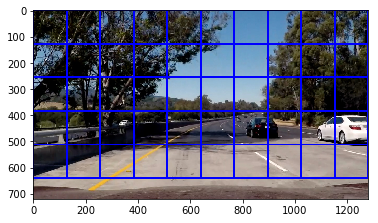

In [29]:
image = testimages[0]
windows=[]
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0, 0))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)


In [30]:
def find_cars_old(img, clf, scaler, params, y_start_stop=[360, 700], xy_window=(64, 64), xy_overlap=(0.80, 0.80) ):
    #1) Create an empty list to receive positive detection windows
    car_windows = []
    windows = slide_window(img, y_start_stop=y_start_stop, xy_window=xy_window, xy_overlap=xy_overlap)
    #2) Iterate over all windows in the list
    for window in windows:
        img_window = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        features = extract_features(img_window, params)
        scaled_features = scaler.transform(features.reshape(1, -1))
        pred = clf.predict(scaled_features)
        if pred == 1:
            car_windows.append(window)
    return car_windows

In [31]:
def find_cars(img, clf, scaler, params, y_start_stop=[350, 650], window=64, cells_per_step=1, scale=1.5 ):
    cspace = params.cspace
    orient = params.orient
    pix_per_cell = params.pix_per_cell
    cell_per_block = params.cell_per_block
    hog_channel = params.hog_channel
    # Spatial parameters
    size = params.size
    # Histogram parameters
    hist_bins = params.hist_bins
    hist_range = params.hist_range
    
    # Image color space changes
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    
    ystart, ystop = y_start_stop
    ctrans_tosearch = feature_image[ystart:ystop,:,:]
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    car_windows = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=size)
            hist_features = color_hist(subimg, nbins=hist_bins, bins_range=hist_range)
            
            # Scale features and make a prediction
            test_features = scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = clf.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                car_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return car_windows

In [32]:
def drawCars(img, windows):
    """
    Draw the `windows` on the image `img`.
    """
    output = np.copy(img)
    return draw_boxes(output, windows)

In [33]:
def showImages(images, cmap = None, cols = 2, rows = 3, figsize=(15,13)):
    """
    Display `images` on a [`cols`, `rows`] subplot grid.
    """
    imgLength = len(images)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    indexes = range(cols * rows)
    for ax, index in zip(axes.flat, indexes):
        if index < imgLength:
            image = images[index]
            if cmap == 'hot':
                ax.imshow(image, cmap='hot')
            else:
                ax.imshow(image)

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


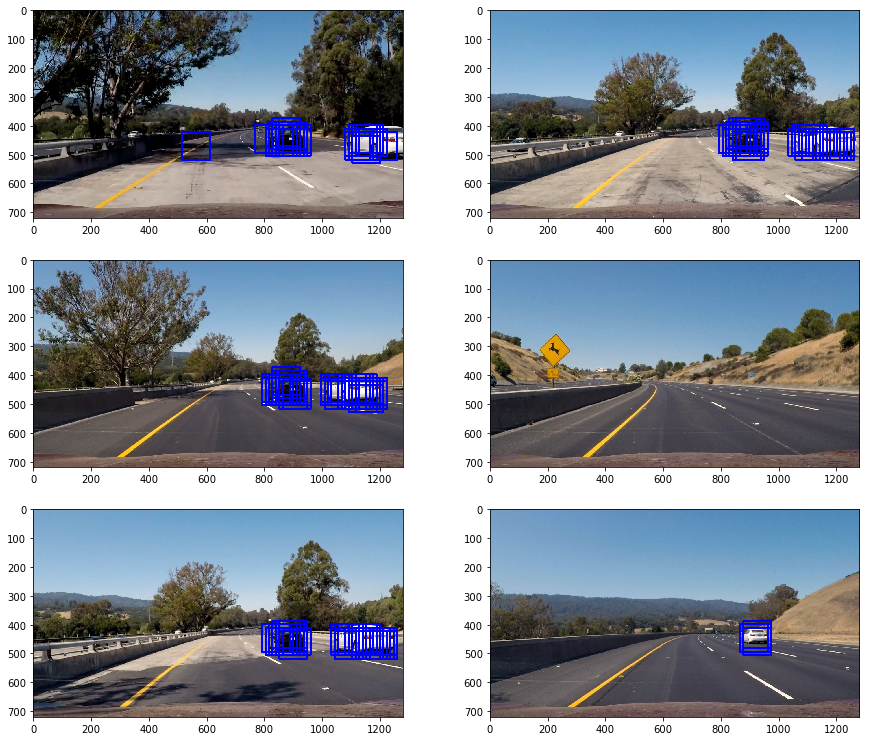

In [34]:
# find_Cars(img, clf, scaler, params, y_start_stop=[350, 650], window=64, cells_per_step=1, scale=1.5 )
rectangles = list(map(lambda img: find_cars(img, svc, X_scaler, params), testimages))
img_windows = list(map(lambda imgPlusBox: drawCars(imgPlusBox[0], imgPlusBox[1]), zip(testimages, rectangles)))
showImages(img_windows)

## heat map

In [35]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [36]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [37]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [38]:
def get_bboxes(img, boxes, threshold = 6):
    heatmap = add_heat(np.zeros(img.shape), boxes)
    heatmap = apply_threshold(heatmap, threshold)
    labels = label(heatmap)
        
    return draw_labeled_bboxes(np.copy(img), labels)

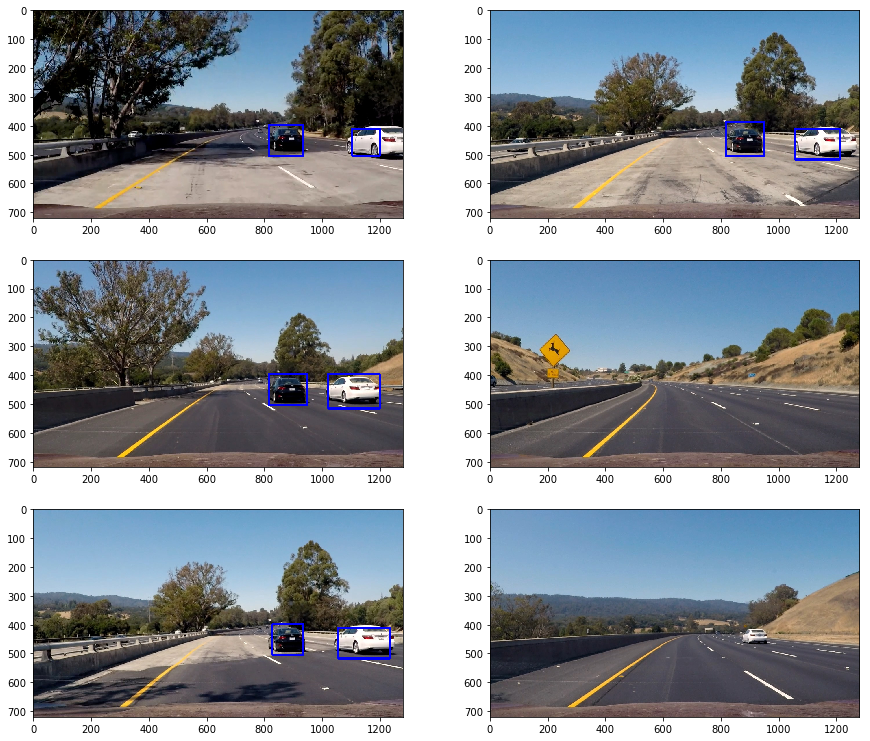

In [39]:
img_thresholded = list(map(lambda imgPlusBox: get_bboxes(imgPlusBox[0], imgPlusBox[1], threshold=5), zip(testimages, rectangles)))
showImages(img_thresholded)

In [40]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import queue
from functools import reduce


In [41]:
class HeatHistory():
    def __init__(self):
        self.history = []

def processVideo(inputVideo, outputVideo, heat_frames=10, heat_threshhold=5):
    """
    Process the video `inputVideo` to find the cars and saves the video to `outputVideo`.
    """
    history = HeatHistory()

    def pipeline(img):
        boxes = find_cars(img, svc, X_scaler, params)
        img_shape = img.shape
        heatmap = add_heat(np.zeros(img_shape), boxes)
        if len(history.history) >= heat_frames:
            history.history = history.history[1:]

        history.history.append(heatmap)
        heat_history = reduce(lambda h, acc: h + acc, history.history)/heat_frames
        heatmap = apply_threshold(heat_history, heat_threshhold)
        labels = label(heatmap)

        return draw_labeled_bboxes(np.copy(img), labels)

    myclip = VideoFileClip(inputVideo)
    output_video = myclip.fl_image(pipeline)
    output_video.write_videofile(outputVideo, audio=False)
    
processVideo('./subclip_25_35.mp4', './out_heat_history_video.mp4', heat_frames=10, heat_threshhold=5)

[MoviePy] >>>> Building video ./out_heat_history_video.mp4
[MoviePy] Writing video ./out_heat_history_video.mp4


100%|█████████▉| 250/251 [08:17<00:01,  1.98s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./out_heat_history_video.mp4 



In [42]:
processVideo('./project_video.mp4', './out_video.mp4', heat_frames=10, heat_threshhold=5)

[MoviePy] >>>> Building video ./out_video.mp4
[MoviePy] Writing video ./out_video.mp4


100%|█████████▉| 1260/1261 [41:46<00:02,  2.01s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./out_video.mp4 

